# Reparameterization of the Birkhoff Polytope

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# First consider sampling a random permutation matrix
def sample_permutation(N, p, verbose=False):
    """
    Raster scan and sample
    """
    P = np.zeros((N,N), dtype=int)
    for i in range(N-1):
        for j in range(N-1):
            # Upper bounded by partial row sum
            ub_row = 1 - np.sum(P[i,:j])
            
            # Upper bounded by partial column sum
            ub_col = 1 - np.sum(P[:i,j])
            
            # Lower bounded (see notes)
            lb_rem = (1 - np.sum(P[i,:j])) - (N - (j + 1)) + np.sum(P[:i,j+1:])
            
            # Combine constraints
            ub = min(ub_row, ub_col)
            lb = max(0, lb_rem)
            
            if verbose:
                print("({0}, {1}): lb_rem: {2} lb: {3}  ub: {4}".format(i,j,lb_rem,lb,ub))
            
            # Sample
            if lb == 0 and ub == 1:
                P[i,j] = np.random.rand() < p
            else:
                assert lb == ub
                P[i,j] = lb
        
        # Finish off the row
        P[i,-1] = 1-np.sum(P[i,:-1])
        
    # Finish off the columns
    for j in range(N):
        P[-1,j] = 1-np.sum(P[:-1,j])
    
    return P

def check_permutation(P):
    assert np.allclose(P.sum(0), 1)
    assert np.allclose(P.sum(1), 1)
    assert np.min(P) == 0
    assert np.max(P) == 1
    

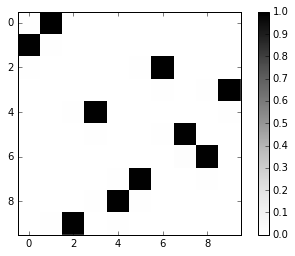

In [5]:
N = 10
for _ in range(100): 
    P = sample_permutation(N, 2./N)
    check_permutation(P)


plt.imshow(P, vmin=0, vmax=1, interpolation="none", cmap="Greys")
plt.colorbar()

In [6]:
# First consider sampling a random doubly stochastic matrix
def logistic(psi):
    return 1./(1+np.exp(-psi))

def sample_doubly_stochastic(Psi, verbose=False):
    """
    Same as above but with a sample on the interval (lb, ub)
    """
    N = Psi.shape[0] + 1
    assert Psi.shape == (N-1,N-1)
    
    P = np.zeros((N,N), dtype=float)
    for i in range(N-1):
        for j in range(N-1):
            # Upper bounded by partial row sum
            ub_row = 1 - np.sum(P[i,:j])
            
            # Upper bounded by partial column sum
            ub_col = 1 - np.sum(P[:i,j])
            
            # Lower bounded (see notes)
            lb_rem = (1 - np.sum(P[i,:j])) - (N - (j + 1)) + np.sum(P[:i,j+1:])
            
            # Combine constraints
            ub = min(ub_row, ub_col)
            lb = max(0, lb_rem)
            
            if verbose:
                print("({0}, {1}): lb_rem: {2} lb: {3}  ub: {4}".format(i,j,lb_rem,lb,ub))
            
            # Sample
            P[i,j] = lb + (ub - lb) * logistic(Psi[i,j])
            
        # Finish off the row
        P[i,-1] = 1-np.sum(P[i,:-1])
        
    # Finish off the columns
    for j in range(N):
        P[-1,j] = 1-np.sum(P[:-1,j])
    
    return P

def check_doubly_stochastic(P):
    assert np.allclose(P.sum(0), 1)
    assert np.allclose(P.sum(1), 1)
    assert np.min(P) >= 0
    assert np.max(P) <= 1


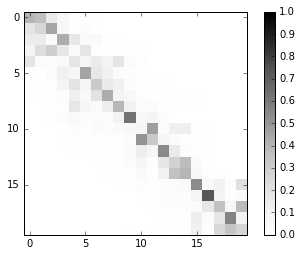

In [7]:
N = 20
tau = 1.0
Psi = tau * np.random.randn(N-1, N-1)

P = sample_doubly_stochastic(Psi)
check_doubly_stochastic(P)

plt.imshow(P, vmin=0, vmax=1, interpolation="none", cmap="Greys")
plt.colorbar()

In [11]:
# First consider sampling a random doubly stochastic matrix
def logistic(psi):
    return 1./(1+np.exp(-psi))

def sample_doubly_stochastic_stable(Psi, tol=1e-4, verbose=False):
    """
    Same as above but with a sample on the interval (lb, ub).
    If (ub - lb < tol) then sample the entry from (lb=0, ub=tol).
    This deterministic transformation will result in matrices that 
    like outside the Birkhoff polytope (by up to N*tol) but should 
    be more stable to sample and invert. 
    """
    N = Psi.shape[0] + 1
    assert Psi.shape == (N-1,N-1)
    
    P = np.zeros((N,N), dtype=float)
    for i in range(N-1):
        for j in range(N-1):
            # Upper bounded by partial row sum
            ub_row = 1 - np.sum(P[i,:j])
            
            # Upper bounded by partial column sum
            ub_col = 1 - np.sum(P[:i,j])
            
            # Lower bounded (see notes)
            lb_rem = (1 - np.sum(P[i,:j])) - (N - (j + 1)) + np.sum(P[:i,j+1:])
            
            # Combine constraints
            ub = min(ub_row, ub_col)
            lb = max(0, lb_rem)
            
            if verbose:
                print("({0}, {1}): lb_rem: {2} lb: {3}  ub: {4}".format(i,j,lb_rem,lb,ub))
            
            # Check if difference is less than allowable tolerance
            if ub - lb < tol:
                P[i,j] = tol * logistic(Psi[i,j])
            else:
                P[i,j] = lb + (ub - lb) * logistic(Psi[i,j])
            
        # Finish off the row
        P[i,-1] = 1-np.sum(P[i,:-1])
        
    # Finish off the columns
    for j in range(N):
        P[-1,j] = 1-np.sum(P[:-1,j])
    
    return P

def check_doubly_stochastic_stable(P, tol=1e-4):
    N = P.shape[0]
    assert np.allclose(P.sum(0), 1, atol=N*tol)
    assert np.allclose(P.sum(1), 1, atol=N*tol)
    assert np.min(P) >= -N*tol
    assert np.max(P) <= 1+N*tol
    print("P min: {0:.5f} max {1:.5f}".format(P.min(), P.max()))


P min: -0.00445 max 0.68219


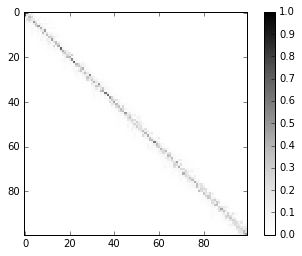

In [12]:
N = 100
tau = 1.0
Psi = tau * np.random.randn(N-1, N-1)

P = sample_doubly_stochastic_stable(Psi)
check_doubly_stochastic_stable(P)

plt.imshow(P, vmin=0, vmax=1, interpolation="none", cmap="Greys")
plt.colorbar()

In [49]:
# Now try in log space 
from scipy.misc import logsumexp

def log_logistic(psi):
    return -np.log1p(np.exp(-psi))

def sample_doubly_stochastic_log(Psi, verbose=False):
    """
    Same as above but in log space 
    """
    N = Psi.shape[0] + 1
    assert Psi.shape == (N-1,N-1)
    
    log_P = np.zeros((N,N), dtype=float)
    for i in range(N-1):
        for j in range(N-1):
            # Upper bounded by partial row sum
            terms = np.concatenate(([np.log(1)], log_P[i,:j]))
            signs = -1 * np.ones_like(terms)
            signs[0] = 1
            log_ub_row = logsumexp(terms, b=signs)
#             ub_row = 1 - np.sum(P[i,:j])
#             assert np.allclose(np.log(ub_row), log_ub_row)
            assert np.isfinite(log_ub_row)
            
            # Upper bounded by partial column sum
            terms = np.concatenate(([np.log(1)], log_P[:i,j]))
            signs = -1 * np.ones_like(terms)
            signs[0] = 1
            log_ub_col = logsumexp(terms, b=signs)
            assert np.isfinite(log_ub_col)
#             ub_col = 1 - np.sum(P[:i,j])
#             assert np.allclose(np.log(ub_col), log_ub_col)
            
            # Lower bounded (see notes)
            terms = np.concatenate(
                [[np.log(1)], log_P[i,:j], [np.log(N-(j+1))], np.ravel(log_P[:i,j+1:])])
            signs = np.concatenate(
                [[1], -1 * np.ones(log_P[i,:j].size), [-1], np.ones(log_P[:i,j+1:].size)])
            log_lb_rem = logsumexp(terms, b=signs)
            
#             lb_rem = 1 - np.sum(P[i,:j]) - (N - (j + 1)) + np.sum(P[:i,j+1:]
#             if lb_rem > 0:
#                 assert np.allclose(np.log(lb_rem), log_lb_rem)
            
            # Combine constraints
            log_ub = min(log_ub_row, log_ub_col)
            log_lb = log_lb_rem if not np.isnan(log_lb_rem) else -np.inf
#             ub = min(ub_row, ub_col)
#             lb = max(0, lb_rem)
            
            if verbose:
                print("({0}, {1}): log lb_rem: {2} log lb: {3}  log ub: {4}"
                      .format(i, j, log_lb_rem, log_lb, log_ub))
            
            # Sample
#             P[i,j] = lb + (ub - lb) * logistic(Psi[i,j])
            log_margin = logsumexp([log_ub, log_lb], b=[1, -1])
            log_P[i,j] = logsumexp([log_lb, log_margin + log_logistic(Psi[i,j])])
#             assert np.allclose(log_P[i,j], np.log(P[i,j]))
            
        # Finish off the row
#         P[i,-1] = 1-np.sum(P[i,:-1])
        terms = np.concatenate(([np.log(1)], log_P[i,:-1]))
        signs = -1 * np.ones_like(terms)
        signs[0] = 1
        log_P[i,-1] = logsumexp(terms, b=signs)
#         assert np.allclose(log_P[i,-1], np.log(P[i,-1]))
        
    # Finish off the columns
    for j in range(N):
#         P[-1,j] = 1-np.sum(P[:-1,j])
        terms = np.concatenate(([np.log(1)], log_P[:-1,j]))
        signs = -1 * np.ones_like(terms)
        signs[0] = 1
        log_P[-1,j] = logsumexp(terms, b=signs)
#         assert np.allclose(log_P[-1,j], np.log(P[-1,j]))
        
    return log_P


In [52]:
N = 10
tau = 1.0
Psi = tau * np.random.randn(N-1, N-1)

log_P = sample_doubly_stochastic_log(Psi)
P = np.exp(log_P)
check_doubly_stochastic(P)

plt.imshow(P, vmin=0, vmax=1, interpolation="none", cmap="Greys")
plt.colorbar()

AssertionError: 

In [50]:
N = 100
tau = 1.0
Psi = tau * np.random.randn(N-1, N-1)

log_P = sample_doubly_stochastic_log(Psi, verbose=False)
P = np.exp(log_P)
# check_doubly_stochastic(P)

plt.imshow(P, vmin=0, vmax=1, interpolation="none", cmap="Greys")
plt.colorbar()

print(P.min())
print(P.max())

/Users/scott/anaconda3/lib/python3.5/site-packages/scipy/misc/common.py:173: RuntimeWarning: invalid value encountered in log
  out = log(s)


AssertionError: 

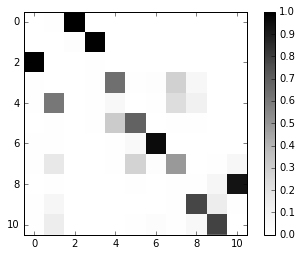

In [27]:
N = 10
tau = 10.0
Psi = tau * np.random.randn(N, N)

P = sample_doubly_stochastic(Psi)
check_doubly_stochastic(P)

plt.imshow(P, vmin=0, vmax=1, interpolation="none", cmap="Greys")
plt.colorbar()

In [13]:
# Check the density calculations
def logit(pi):
    return np.log(pi/(1-pi))

def invert_Pi(P, verbose=False):
    """
    Invert Pi to get Psi. Note that this is pretty unstable for large N and tau.
    """
    N = P.shape[0]
    assert P.shape == (N,N)
    
    Psi = np.zeros((N-1,N-1), dtype=float)
    for i in range(N-1):
        for j in range(N-1):
            # Upper bounded by partial row sum
            ub_row = 1 - np.sum(P[i,:j])
            # Upper bounded by partial column sum
            ub_col = 1 - np.sum(P[:i,j])
            
            # Lower bounded (see notes)
            lb_rem = (1 - np.sum(P[i,:j])) - (N - (j + 1)) + np.sum(P[:i,j+1:])

            # Combine constraints
            ub = min(ub_row, ub_col)
            lb = max(0, lb_rem)
            
            if verbose:
                print("({0}, {1}): lb_rem: {2} lb: {3}  ub: {4}".format(i,j,lb_rem,lb,ub))
            
            # Check if difference is less than allowable tolerance
            Psi[i,j] = logit((P[i,j] - lb) / (ub - lb))
                
            assert np.isfinite(Psi[i,j])
        
    return Psi

In [14]:
# Check the density calculations
def logit(pi):
    return np.log(pi/(1-pi))

def invert_Pi_stable(P, tol=1e-4, verbose=False):
    """
    Invert Pi to get Psi. Note that this is pretty unstable for large N and tau.
    """
    N = P.shape[0]
    assert P.shape == (N,N)
    
    Psi = np.zeros((N-1,N-1), dtype=float)
    for i in range(N-1):
        for j in range(N-1):
            # Upper bounded by partial row sum
            ub_row = 1 - np.sum(P[i,:j])
            # Upper bounded by partial column sum
            ub_col = 1 - np.sum(P[:i,j])
            
            # Lower bounded (see notes)
            lb_rem = (1 - np.sum(P[i,:j])) - (N - (j + 1)) + np.sum(P[:i,j+1:])
                
            # Combine constraints
            ub = min(ub_row, ub_col)
            lb = max(0, lb_rem)
            
            if verbose:
                print("({0}, {1}): lb_rem: {2} lb: {3}  ub: {4}".format(i,j,lb_rem,lb,ub))
            
            # Check if difference is less than allowable tolerance
            if ub - lb < tol:
                Psi[i,j] = logit(P[i,j] / tol)
            else:
                Psi[i,j] = logit((P[i,j] - lb) / (ub - lb))
                
            assert np.isfinite(Psi[i,j])
        
    return Psi

2.81552559045e-13


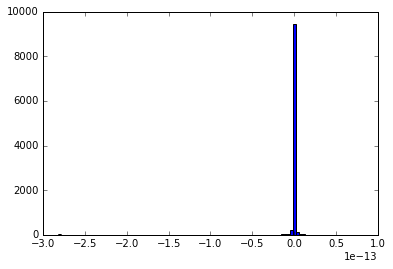

In [23]:
N = 100
tau = 2.0
Psi = tau * np.random.randn(N, N)

P = sample_doubly_stochastic_stable(Psi)
Psi2 = invert_Pi_stable(P)
print(abs(Psi-Psi2).max())
plt.hist(Psi.ravel() - Psi2.ravel(), 100)
pass

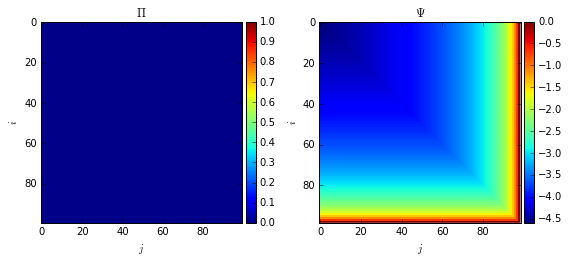

In [16]:
# What does the inverse of the "uniform" doubly stochastic matrix look like?
N = 100

Pi = 1./N *np.ones((N,N))
Psi = invert_Pi_stable(Pi)


from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
im1 = plt.imshow(Pi, vmin=0, vmax=1)
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Pi$")

divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(Psi, interpolation="none")
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Psi$")

divider = make_axes_locatable(ax2)
cb2 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb2)
plt.colorbar(im2, cax=cb2)

plt.tight_layout()
# plt.savefig("uniform_pi_psi.png")

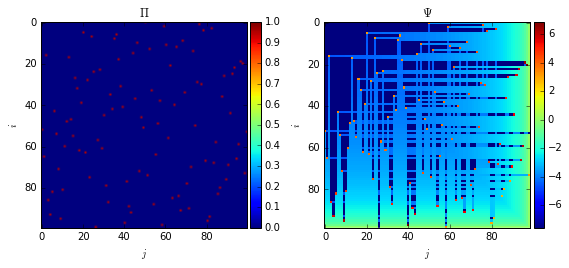

In [17]:
# What does the inverse of the "uniform" doubly stochastic matrix look like?
N = 100

p1 = np.random.permutation(N)
P1 = np.zeros((N,N))
P1[np.arange(N), p1] = 1

P2 = 1./N * np.ones((N,N))

alpha = 0.95
Pi = alpha * P1 + (1-alpha) * P2 
check_doubly_stochastic(Pi)

Psi = invert_Pi_stable(Pi)


from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
im1 = plt.imshow(Pi, vmin=0, vmax=1)
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Pi$")

divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(Psi, interpolation="none")
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Psi$")

divider = make_axes_locatable(ax2)
cb2 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb2)
plt.colorbar(im2, cax=cb2)

plt.tight_layout()
plt.savefig("random_pi_psi.png")

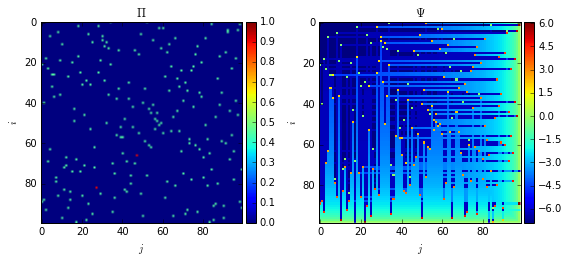

In [18]:
# What does the inverse of the "uniform" doubly stochastic matrix look like?
N = 100

p1 = np.random.permutation(N)
P1 = np.zeros((N,N))
P1[np.arange(N), p1] = 1

p2 = np.random.permutation(N)
P2 = np.zeros((N,N))
P2[np.arange(N), p2] = 1

P3 = 1./N * np.ones((N,N))

alpha = [0.45, 0.45]
Pi = alpha[0] * P1 + alpha[1] * P2 + (1-alpha[0]-alpha[1]) * P3
check_doubly_stochastic(Pi)

Psi = invert_Pi_stable(Pi)


from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
im1 = plt.imshow(Pi, vmin=0, vmax=1)
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Pi$")

divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(Psi, interpolation="none")
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Psi$")

divider = make_axes_locatable(ax2)
cb2 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb2)
plt.colorbar(im2, cax=cb2)

plt.tight_layout()
plt.savefig("twoperm_pi_psi.png")

P min: 0.00001 max 0.33914
1.32546201774e-05
0.33914073265


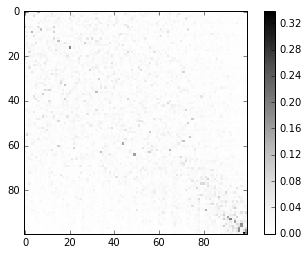

In [20]:
# Sample from distribution with uniform mean
Pi = 1./N * np.ones((N,N))
check_doubly_stochastic(Pi)

# Use this as the mean
mu = invert_Pi_stable(Pi)
tau = 1.0
# Psi = mu + 1./tau * np.random.randn(N-1, N-1)
Psi = (mu + np.random.randn(N-1, N-1)) / tau

P = sample_doubly_stochastic_stable(Psi, verbose=False)
check_doubly_stochastic_stable(P)

plt.imshow(P, vmin=0,  interpolation="none", cmap="Greys")
plt.colorbar()

print(P.min())
print(P.max())

P min: -0.00220 max 1.00000


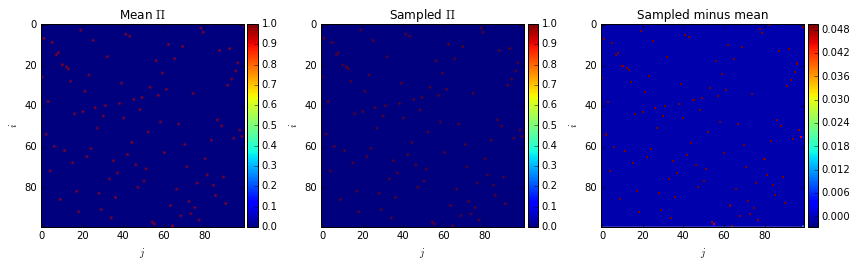

In [21]:
# Sample from distribution with given permutation as mean
p1 = np.random.permutation(N)
P1 = np.zeros((N,N))
P1[np.arange(N), p1] = 1
P2 = 1./N * np.ones((N,N))
alpha = 0.95
Pi = alpha * P1 + (1-alpha) * P2 
check_doubly_stochastic(Pi)

# Use this as the mean
mu = invert_Pi_stable(Pi)
tau = 0.1
# Psi = mu + 1./tau * np.random.randn(N-1, N-1)
Psi = (mu + np.random.randn(N-1, N-1)) / tau

P = sample_doubly_stochastic_stable(Psi, verbose=False)
check_doubly_stochastic_stable(P)


from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
im1 = plt.imshow(Pi, vmin=0, vmax=1)
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("Mean $\Pi$")

divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

ax1 = fig.add_subplot(132)
im1 = plt.imshow(P, vmin=0, vmax=1)
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("Sampled $\Pi$")

divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

ax2 = fig.add_subplot(133)
im2 = ax2.imshow(P-Pi, interpolation="none")
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("Sampled minus mean")

divider = make_axes_locatable(ax2)
cb2 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb2)
plt.colorbar(im2, cax=cb2)

plt.tight_layout()

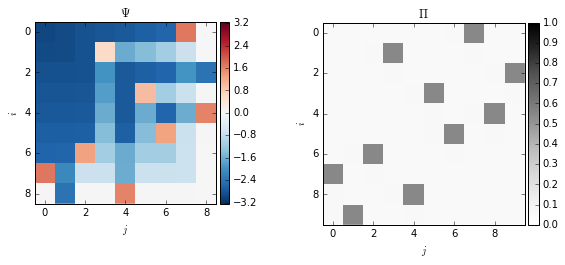

In [22]:
# What does the inverse of the "uniform" doubly stochastic matrix look like?
N = 10

p1 = np.random.permutation(N)
P1 = np.zeros((N,N))
P1[np.arange(N), p1] = 1

p2 = np.random.permutation(N)
P2 = np.zeros((N,N))
P2[np.arange(N), p2] = 1

P3 = 1./N * np.ones((N,N))

alpha = [0.5, 0.]
Pi = alpha[0] * P1 + alpha[1] * P2 + (1-alpha[0]-alpha[1]) * P3
check_doubly_stochastic(Pi)

Psi = invert_Pi_stable(Pi)
Psi_lim = abs(Psi).max()


from mpl_toolkits.axes_grid1 import make_axes_locatable
from hips.plotting.layout import create_axis_at_location

fig = plt.figure(figsize=(8,4))

ax2 = create_axis_at_location(fig, 0.5, 0.5 + (1./N) * 3., float(N-1)/N *3, float(N-1)/N * 3)
# ax2 = fig.add_subplot(121)
im2 = ax2.imshow(Psi, vmin=-1.1*Psi_lim, vmax=1.1*Psi_lim, interpolation="none", cmap="RdBu_r")
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Psi$")

divider = make_axes_locatable(ax2)
cb2 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb2)
plt.colorbar(im2, cax=cb2)

# ax1 = fig.add_subplot(122)
ax1 = create_axis_at_location(fig, 4.5, 0.5, 3, 3)
im1 = plt.imshow(Pi, vmin=0, vmax=1, interpolation="none", cmap="Greys")
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Pi$")

divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

# plt.tight_layout()
plt.savefig("pi_psi_10.png")